Лучшие метрики модели SARIMAX, полученные коллегой на этом же датасете:
- MAE: 0.032853528555852385
- MSE: 0.0012413360200539234
- RMSE: 0.035232598826284774
- MAPE: 0.1701346412714233%

План по УИРУ:
1) Посмотреть еще техники описательной статистики для данных

2) Дальше заняться генерацией признаков:
- 2.1) признаки, которые сигнализируют простой/его близость и тд. Чтобы лучше считать предсказания на разрывах мб(?)
- 2.2) Заполнение малых пропусков интерполяцией
- 2.3) временные и лаговые признаки
- 2.4) признаки преобразования и различные статистики

2) Часть с тренировкой модели:
- 3.1) Написать пайплайн с тюнингом гиперпараметров модели в зависимости от количества моделей/типа фич, которые были выбраны.
- 3.2) Написать пайплайн по permutation importance для отбора фич

In [2]:
from copy import deepcopy
from importlib import reload

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMRegressor
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)


from features import make_features, prepare_data
from utils import plot_result, set_seed, reduce_mem_usage, get_nan_intervals
from training import tuning_pipeline, make_permutation_and_feature_importance


set_seed(42)

In [4]:
data = pd.read_excel('Prism_МоДеРо.xlsx', skiprows=3, usecols='I:Z')
data = data.rename(columns={'Код сигнала': 'Date'})

Окинем взглядом данные

In [6]:
data.head()

,Date,F1,Pa,Pr,Td,Tg,Tst,Тп. ЦНД-1\n,Тп.ЦНД-2\n,Т ГПЗ н.А,Т ГПЗ н.Б,Т ГПЗ н.В,Т ГПЗ н.Г,Т турб. н.А,Т турб.н.Б,Т турб.н.В,Т турб.н.Г,Fr
0,2016-01-01 00:00:00,19.282400,134.753082,-90.211281,37.487492,31.800579,45.405594,9.033,12.256,539.282,540.747,541.553,545.215,548.950,548.657,545.288,545.801,49.995281
1,2016-01-01 01:00:00,19.283903,134.220016,-86.393089,37.478737,31.870878,45.505035,8.936,12.256,539.209,540.234,541.553,544.482,550.562,549.683,545.874,546.826,50.005314
2,2016-01-01 02:00:00,19.282400,134.415543,-83.297874,37.238052,31.816473,45.399033,9.033,12.280,541.992,541.992,541.333,545.581,553.491,552.246,549.170,549.243,50.002312
3,2016-01-01 03:00:00,19.286156,134.487137,-90.895683,37.348053,31.711052,45.473736,9.082,12.256,539.868,540.747,541.699,543.970,552.612,551.733,548.364,548.438,50.001530
4,2016-01-01 04:00:00,19.283903,132.702866,-95.911263,37.513912,31.732071,45.622948,9.082,12.256,537.964,538.989,540.454,542.432,552.979,551.440,548.804,549.023,50.022942


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6679 non-null   datetime64[ns]
 1   F1           6679 non-null   float64       
 2   Pa           6679 non-null   float64       
 3   Pr           6679 non-null   float64       
 4   Td           6679 non-null   float64       
 5   Tg           6679 non-null   float64       
 6   Tst          6679 non-null   float64       
 7   Тп. ЦНД-1
   6679 non-null   float64       
 8   Тп.ЦНД-2
    6679 non-null   float64       
 9   Т ГПЗ н.А    6679 non-null   float64       
 10  Т ГПЗ н.Б    6679 non-null   float64       
 11  Т ГПЗ н.В    6679 non-null   float64       
 12  Т ГПЗ н.Г    6679 non-null   float64       
 13  Т турб. н.А  6679 non-null   float64       
 14  Т турб.н.Б   6679 non-null   float64       
 15  Т турб.н.В   6679 non-null   float64       
 16  Т турб

### Генерация признаков

Для формирования расширенного набора признаков используется функция генерации признаков, реализованная в модуле `features` (временные метки, лаги, скользящие статистики по окнам, полиномиальные признаки, экспоненциальное сглаживание, разности лагов).


In [8]:
df = prepare_data(data)
dct = deepcopy(df)

In [9]:
dct

,Date,y,is_run,hour_off,hour_on,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,...,delta_lag_9lag_82,delta_lag_9lag_8_delta_lag_10lag_9,delta_lag_9lag_8_delta_lag_11lag_10,delta_lag_9lag_8_delta_lag_12lag_11,delta_lag_10lag_92,delta_lag_10lag_9_delta_lag_11lag_10,delta_lag_10lag_9_delta_lag_12lag_11,delta_lag_11lag_102,delta_lag_11lag_10_delta_lag_12lag_11,delta_lag_12lag_112
0,2016-01-08 00:00:00,19.284653,1,0,169,0.5,0.866025,0.994522,-0.104528,-0.433884,...,5.625000e-07,-0.000002,5.640000e-07,2.253000e-06,5.076009e-06,-0.000002,-6.768012e-06,5.655040e-07,0.000002,9.024016e-06
1,2016-01-08 01:00:00,19.280148,1,0,170,0.5,0.866025,0.994522,-0.104528,-0.433884,...,9.024016e-06,0.000002,-6.768012e-06,2.259008e-06,5.625000e-07,-0.000002,5.640000e-07,5.076009e-06,-0.000002,5.655040e-07
2,2016-01-08 02:00:00,19.283152,1,0,171,0.5,0.866025,0.994522,-0.104528,-0.433884,...,1.443843e-04,-0.000036,-9.012000e-06,2.707205e-05,9.024016e-06,0.000002,-6.768012e-06,5.625000e-07,-0.000002,5.076009e-06
3,2016-01-08 03:00:00,19.286907,1,0,172,0.5,0.866025,0.994522,-0.104528,-0.433884,...,5.655040e-07,0.000009,-2.259008e-06,-5.640000e-07,1.443843e-04,-0.000036,-9.012000e-06,9.024016e-06,0.000002,5.625000e-07
4,2016-01-08 04:00:00,19.285404,1,0,173,0.5,0.866025,0.994522,-0.104528,-0.433884,...,1.105652e-04,-0.000008,-1.263482e-04,3.158706e-05,5.655040e-07,0.000009,-2.259008e-06,1.443843e-04,-0.000036,9.024016e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6506,2017-01-17 22:00:00,19.304180,1,0,6675,0.5,0.866025,-0.406737,-0.913545,0.781831,...,2.253001e-06,-0.000002,-0.000000e+00,5.636255e-06,2.253001e-06,0.000000,-5.636255e-06,0.000000e+00,-0.000000,1.410002e-05
6507,2017-01-17 23:00:00,19.301928,1,0,6676,0.5,0.866025,-0.406737,-0.913545,0.781831,...,4.569760e-05,0.000010,-1.014676e-05,-0.000000e+00,2.253001e-06,-0.000002,-0.000000e+00,2.253001e-06,0.000000,0.000000e+00
6508,2017-01-18 00:00:00,19.313192,1,0,6677,0.5,0.866025,-0.587785,-0.809017,0.974928,...,1.410754e-05,-0.000025,-5.637756e-06,5.637756e-06,4.569760e-05,0.000010,-1.014676e-05,2.253001e-06,-0.000002,2.253001e-06
6509,2017-01-18 01:00:00,19.303429,1,0,6678,0.5,0.866025,-0.587785,-0.809017,0.974928,...,0.000000e+00,0.000000,-0.000000e+00,-0.000000e+00,1.410754e-05,-0.000025,-5.637756e-06,4.569760e-05,0.000010,2.253001e-06


In [ ]:
preds, val_mape, test_mape, best_model_config, test = tuning_pipeline(dct.drop(columns=['Date']))
print('F1')
plot_result(test.drop(columns=['y']), test['y'].values, preds[24 * 7:])

results = make_permutation_and_feature_importance(
    dct.drop(columns=['Date']), best_model_config
)
best_model = results['filtered_model']
features = results['features']
joblib.dump(best_model, f'service/models/LGBMModel_F1.pkl')
artifacts = pd.DataFrame([
    {'best_model_config': best_model_config, 'features': features}
], index=[0])
artifacts.to_csv(f'service/artifacts/F1.csv', index=False)

  0%|          | 0/75 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's mape: 0.000236192	valid_0's l2: 3.68123e-05
Trial: 0.00023619108834982283
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2497]	valid_0's mape: 0.000236121	valid_0's l2: 3.66052e-05
Trial: 0.00023612021519068253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid_0's mape: 0.0002356	valid_0's l2: 3.69253e-05
Trial: 0.00023559982399121735
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's mape: 0.000235418	valid_0's l2: 3.68426e-05
Trial: 0.00023541664609371616
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's mape: 0.000230963	valid_0's l2: 3.70943e-05
Trial: 0.00023096234116548906
Training until validation scores don't improv

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[386]	valid_0's mape: 0.000224699	valid_0's l2: 3.51956e-05
Base MAPE: val=0.000225, test=0.000234
Used features: 354 / 356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[386]	valid_0's mape: 0.000224699	valid_0's l2: 3.51956e-05
Filtered MAPE: val=0.000225, test=0.000234


In [6]:
val, test = dct.iloc[-168 * 2:-168], dct.iloc[-168:]
model = LGBMRegressor()
model = joblib.load(f'service/models/LGBMModel_F1.pkl')

artifacts = pd.read_csv(f'service/artifacts/F1.csv')
features = eval(artifacts['features'].iloc[0])

X_test = test.drop(columns=['y'])[features]
X_val = val.drop(columns=['y'])[features]

preds = model.predict(pd.concat([X_val, X_test]))
val_mape = mean_absolute_percentage_error(val['y'], preds[:168])
test_mape = mean_absolute_percentage_error(test['y'], preds[168:])
test_mae = mean_absolute_error(test['y'], preds[168:])
test_mse = mean_squared_error(test['y'], preds[168:])
print('F1')
mean_val = np.mean(val.y)
std_val = np.std(val.y)
plot_result(test[['y']], test['y'].values, preds[168:])
print(mean_absolute_error(test['y'], preds[168:]) * 100)
print("MAPE:", test_mape * 100, "%")
print("MAE:", test_mae)
print("MSE:", test_mse)

F1


0.4526797391773053
MAPE: 0.023444746278221587 %
MAE: 0.004526797391773053
MSE: 3.573049053105369e-05


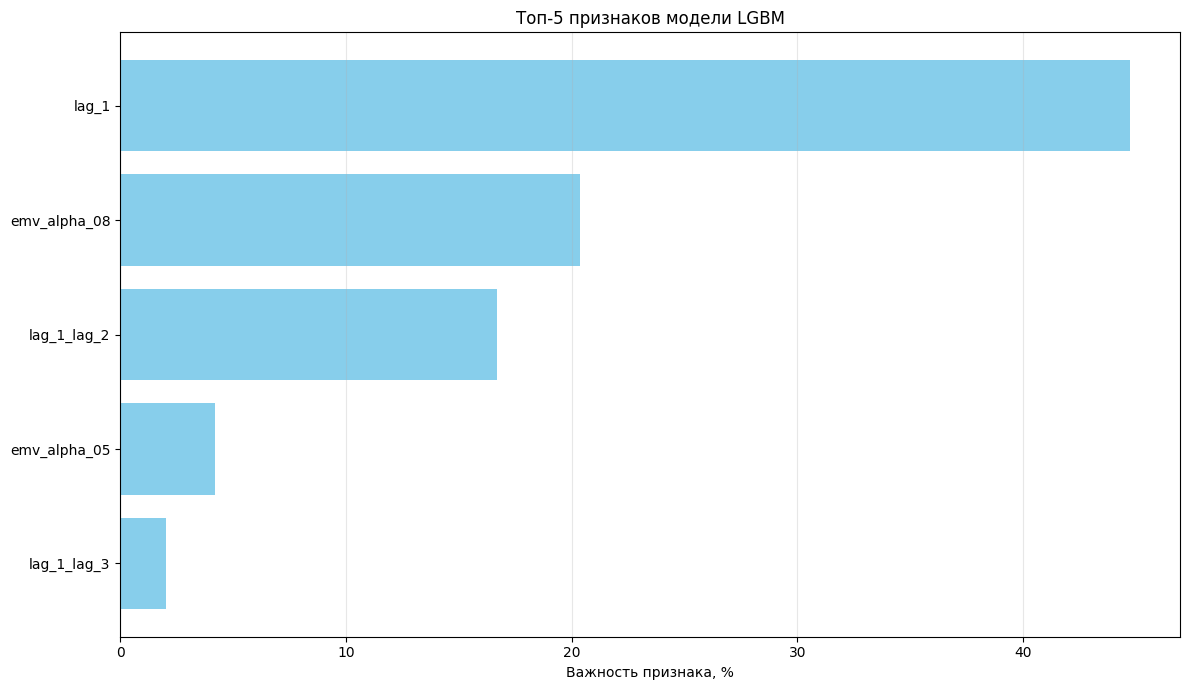

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Берём booster из обученной модели
booster = model.booster_

# Получаем важность признаков по gain
feat_importances = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance': booster.feature_importance(importance_type='gain')
})

# Переводим в проценты
feat_importances['importance_pct'] = 100 * feat_importances['importance'] / feat_importances['importance'].sum()

# Сортируем по убыванию
feat_importances = feat_importances.sort_values(by='importance_pct', ascending=False)

# Берём топ-5
top5 = feat_importances.head(5)

# Построение графика
plt.figure(figsize=(12,7))
plt.barh(top5['feature'][::-1], top5['importance_pct'][::-1], color='skyblue')
plt.xlabel('Важность признака, %')
plt.title('Топ-5 признаков модели LGBM')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('imp.png')
plt.show()


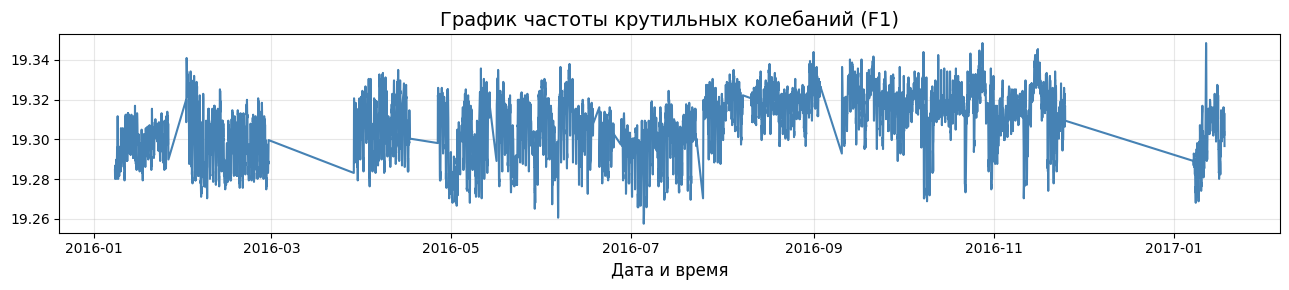

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 3))

plt.plot(
    df['Date'],
    df['y'],
    linewidth=1.5,
    color='steelblue',
    label='Частота крутильных колебаний'
)

plt.xlabel('Дата и время', fontsize=12)
plt.title('График частоты крутильных колебаний (F1)', fontsize=14)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ish')
plt.show()


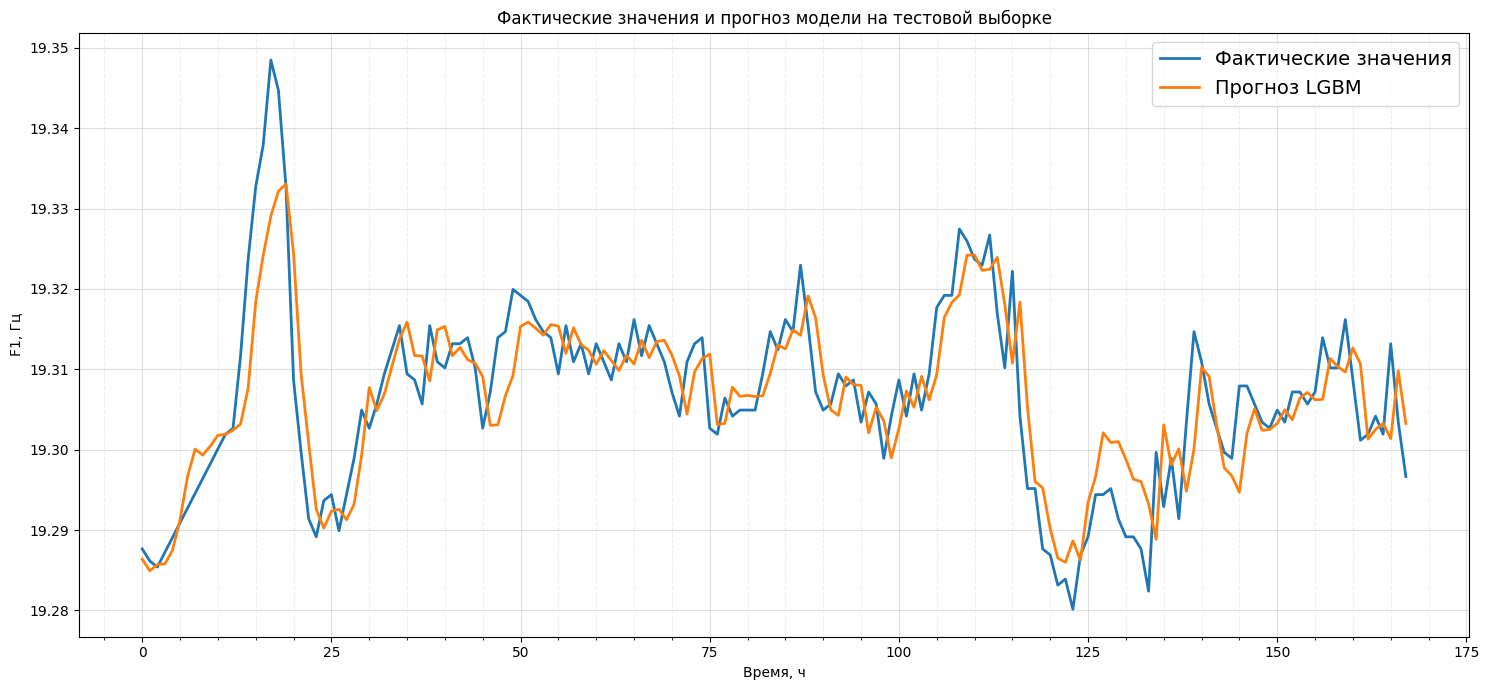

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

def plot_result(y_true, preds, title_suffix=""):
    """
    y_true : array-like
    preds  : array-like
    """

    x = np.arange(len(y_true))

    fig, ax = plt.subplots(figsize=(15, 7))

    ax.plot(x, y_true, label="Фактические значения", linewidth=2)
    ax.plot(x, preds, label="Прогноз LGBM", linewidth=2)

    ax.set_xlabel("Время, ч")
    ax.set_ylabel("F1, Гц")
    ax.set_title(f"Фактические значения и прогноз модели{title_suffix}")

    # Крупные тики — каждые 25 часов
    ax.xaxis.set_major_locator(MultipleLocator(25))

    # Мелкие тики — каждые 5 часов
    ax.xaxis.set_minor_locator(MultipleLocator(5))

    # Сетка
    ax.grid(which="major", alpha=0.4)
    ax.grid(which="minor", alpha=0.2, linestyle="--")

    ax.legend(fontsize=14)

    plt.tight_layout()
    plt.savefig('model')
    plt.show()

plot_result(
    y_true=test['y'].values,
    preds=preds[168:],
    title_suffix=" на тестовой выборке"
)

In [9]:
import ast
artifacts = pd.read_csv(f'service/artifacts/F1.csv')

# Используем ast.literal_eval — это безопаснее и лучше обрабатывает кавычки
features_raw = artifacts['features'].iloc[0]

# Очистка строки, если pandas добавил лишние кавычки при чтении
if isinstance(features_raw, str) and features_raw.startswith('"'):
    features_raw = features_raw.strip('"')

selected_features = ast.literal_eval(features_raw)

In [10]:
curr_history = dct.tail(200).copy().reset_index(drop=True)
horizon = 168
forecasts = []

for h in tqdm(range(horizon)):

    next_date = curr_history['Date'].iloc[-1] + pd.Timedelta(hours=1)
    
    new_row = pd.DataFrame({
        'Date': [next_date],
        'y': [0.0], 
        'is_run': [1],
        'hour_off': [0],
        'hour_on': [curr_history['hour_on'].iloc[-1] + 1]
    })
    
    temp_history = pd.concat([curr_history, new_row], ignore_index=True)
    
    all_features = make_features(temp_history)
    
    X_input = all_features.reindex(columns=selected_features).tail(1)
    
    y_pred = model.predict(X_input)[0]
    
    new_row['y'] = y_pred
    curr_history = pd.concat([curr_history, new_row], ignore_index=True).reset_index(drop=True)
    
    forecasts.append(y_pred)

print(forecasts)

100%|██████████| 168/168 [00:11<00:00, 14.07it/s]

[19.285517530799538, 19.27994848759478, 19.27870920736827, 19.277383679771845, 19.277431878848414, 19.278283793177046, 19.28072863956369, 19.283626835095077, 19.285931744192727, 19.286093489038976, 19.285929069892422, 19.28579344317354, 19.28550662659284, 19.284576801838924, 19.283168360059452, 19.2829240080321, 19.282950133649056, 19.28315192271523, 19.283214255030664, 19.283609362499575, 19.283624843875785, 19.283206963879323, 19.282629530495324, 19.280247462155828, 19.277189567880377, 19.27521091413013, 19.273400693027458, 19.27294918930003, 19.27306193389164, 19.273733907144873, 19.276057065353637, 19.27860615994497, 19.278897459352958, 19.27921228300167, 19.279308802512414, 19.27904619158448, 19.27888562118874, 19.278044247214154, 19.277608254753233, 19.27792786503809, 19.27815313957278, 19.278390032709268, 19.278233401699964, 19.278261920561434, 19.277233896525207, 19.276526223048545, 19.276226292264557, 19.275706775403535, 19.274534906861412, 19.273153242471032, 19.2733788533056

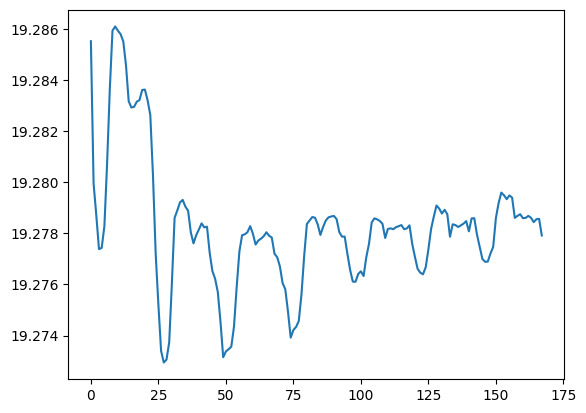

In [11]:
plt.plot(forecasts)


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:01<00:00, 18.60it/s]


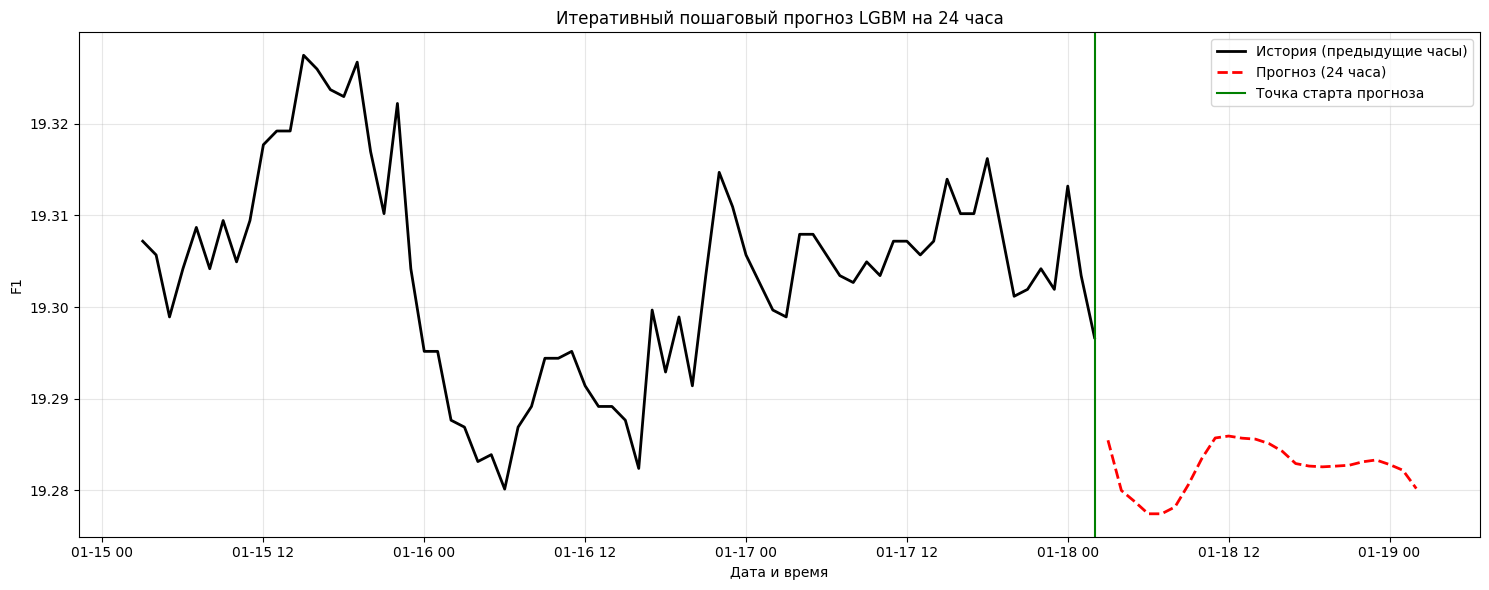

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Настройки
history_hours = 72  # сколько часов истории показать
horizon = 24        # горизонт прогноза

# Берем последние history_hours часов для отображения истории
curr_history = dct.tail(history_hours).copy().reset_index(drop=True)
forecasts = []

for h in tqdm(range(horizon)):
    next_date = curr_history['Date'].iloc[-1] + pd.Timedelta(hours=1)
    
    new_row = pd.DataFrame({
        'Date': [next_date],
        'y': [0.0], 
        'is_run': [1],
        'hour_off': [0],
        'hour_on': [curr_history['hour_on'].iloc[-1] + 1]
    })
    
    temp_history = pd.concat([curr_history, new_row], ignore_index=True)
    
    all_features = make_features(temp_history)
    X_input = all_features.reindex(columns=selected_features).tail(1)
    
    y_pred = model.predict(X_input)[0]
    new_row['y'] = y_pred
    
    curr_history = pd.concat([curr_history, new_row], ignore_index=True).reset_index(drop=True)
    forecasts.append(y_pred)

# Построение графика
plt.figure(figsize=(15,6))

# История
plt.plot(curr_history['Date'].iloc[:history_hours], 
         curr_history['y'].iloc[:history_hours], 
         label='История (предыдущие часы)', color='black', linewidth=2)

# Прогноз
plt.plot(curr_history['Date'].iloc[history_hours:history_hours+horizon], 
         forecasts, label='Прогноз (24 часа)', color='red', linestyle='--', linewidth=2)


plt.axvline(x=curr_history['Date'].iloc[history_hours-1], color='green', linestyle='-', label='Точка старта прогноза')

plt.xlabel('Дата и время')
plt.ylabel('F1')
plt.title('Итеративный пошаговый прогноз LGBM на 24 часа')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prg.png')
plt.show()


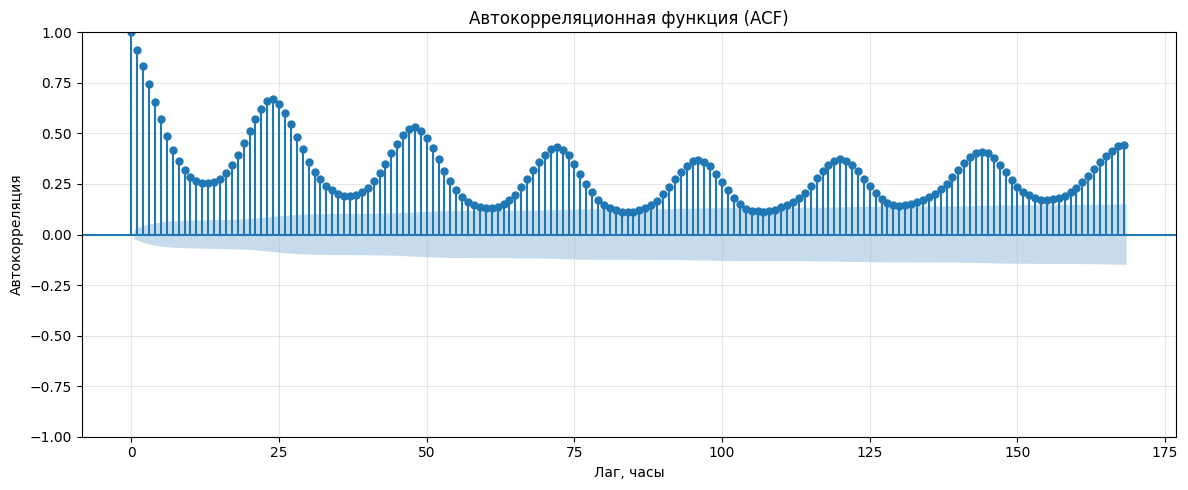

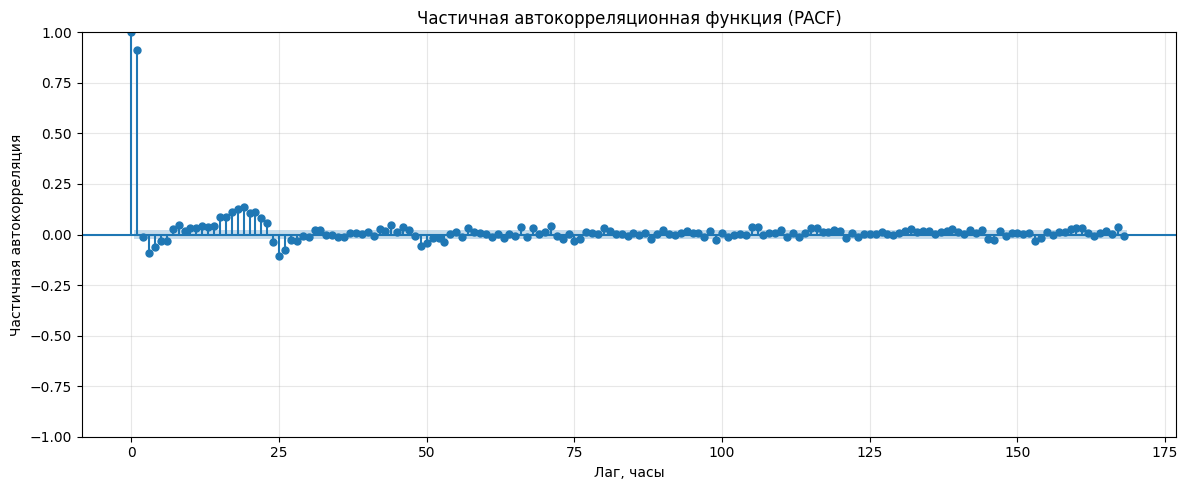

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Целевой временной ряд
series = df['y'].dropna()

# ---------- ACF ----------
plt.figure(figsize=(12, 5))
plot_acf(
    series,
    lags=168,          # до недели при часовой дискретизации
    ax=plt.gca()
)
plt.title("Автокорреляционная функция (ACF)")
plt.xlabel("Лаг, часы")
plt.ylabel("Автокорреляция")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('acf')
plt.show()

# ---------- PACF ----------
plt.figure(figsize=(12, 5))
plot_pacf(
    series,
    lags=168,
    method='ywm',      # устойчивый метод
    ax=plt.gca()
)
plt.title("Частичная автокорреляционная функция (PACF)")
plt.xlabel("Лаг, часы")
plt.ylabel("Частичная автокорреляция")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pacf')
plt.show()
